# BAyesian Python packages

This assumes you have installed several packages by doing something like

> pip install arviz arviz_base arviz_plots arviz_stats pymc bambi preliz kulprit pandas


* PyMC [Probabilistic Programming in Python](https://www.pymc.io/welcome.html)
* ArviZ [Exploratory analysis of Bayesian models](https://arviz-devs.github.io/arviz/)
    * We have been working on a new version 1.0, that will be available soon [Migration guide](https://python.arviz.org/en/stable/user_guide/migration_guide.html)
* Bambi [BAyesian Model Building Interface](https://bambinos.github.io/bambi/)
* Preliz [Exploring and eliciting probability distributions](https://preliz.readthedocs.io/en/latest/)
* Kulprit [Kullback-Leibler projections for Bayesian model selection](https://kulprit.readthedocs.io/en/latest/)
<br>
<br>
* EABM online book [Exploratory Analysis for Bayesian Models](https://eabm.readthedocs.io/en/latest/)

Let's start by importing the packages we will use:

In [1]:
import numpy as np
import pandas as pd

import arviz.preview as az  # after 1.0 release use `import arviz as az`
import bambi as bmb
import kulprit as kpt 
import preliz as pz
import pymc as pm

az.style.use("arviz-variat")


Now we will create some synthetic data to work with:

In [2]:
SEED = 8270
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials, random_state=SEED)
data

array([1, 0, 0, 0])

PyMC models are defined using a context manager. Everything defined within the context manager belongs to the same model.
Here we define a simple model for our data, using a Beta prior for the unknown parameter $\theta$ and a Bernoulli likelihood for the observations:

In [3]:
with pm.Model() as our_first_model:
    # Prior
    θ = pm.Beta('θ', alpha=2., beta=2.)
    # Likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)

We can check that the model has been defined correctly by printing it.

In [4]:
our_first_model

θ ~ Beta(2, 2)
y ~ Bernoulli(θ)

We can also get a visual representation of the model

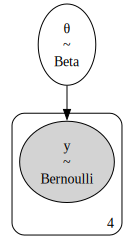

In [5]:
our_first_model.to_graphviz()

PreliZ can be used to better understand distributions. Many of its function accept PyMC distributions directly. For example, we can visualize the prior distribution of $\theta$: 

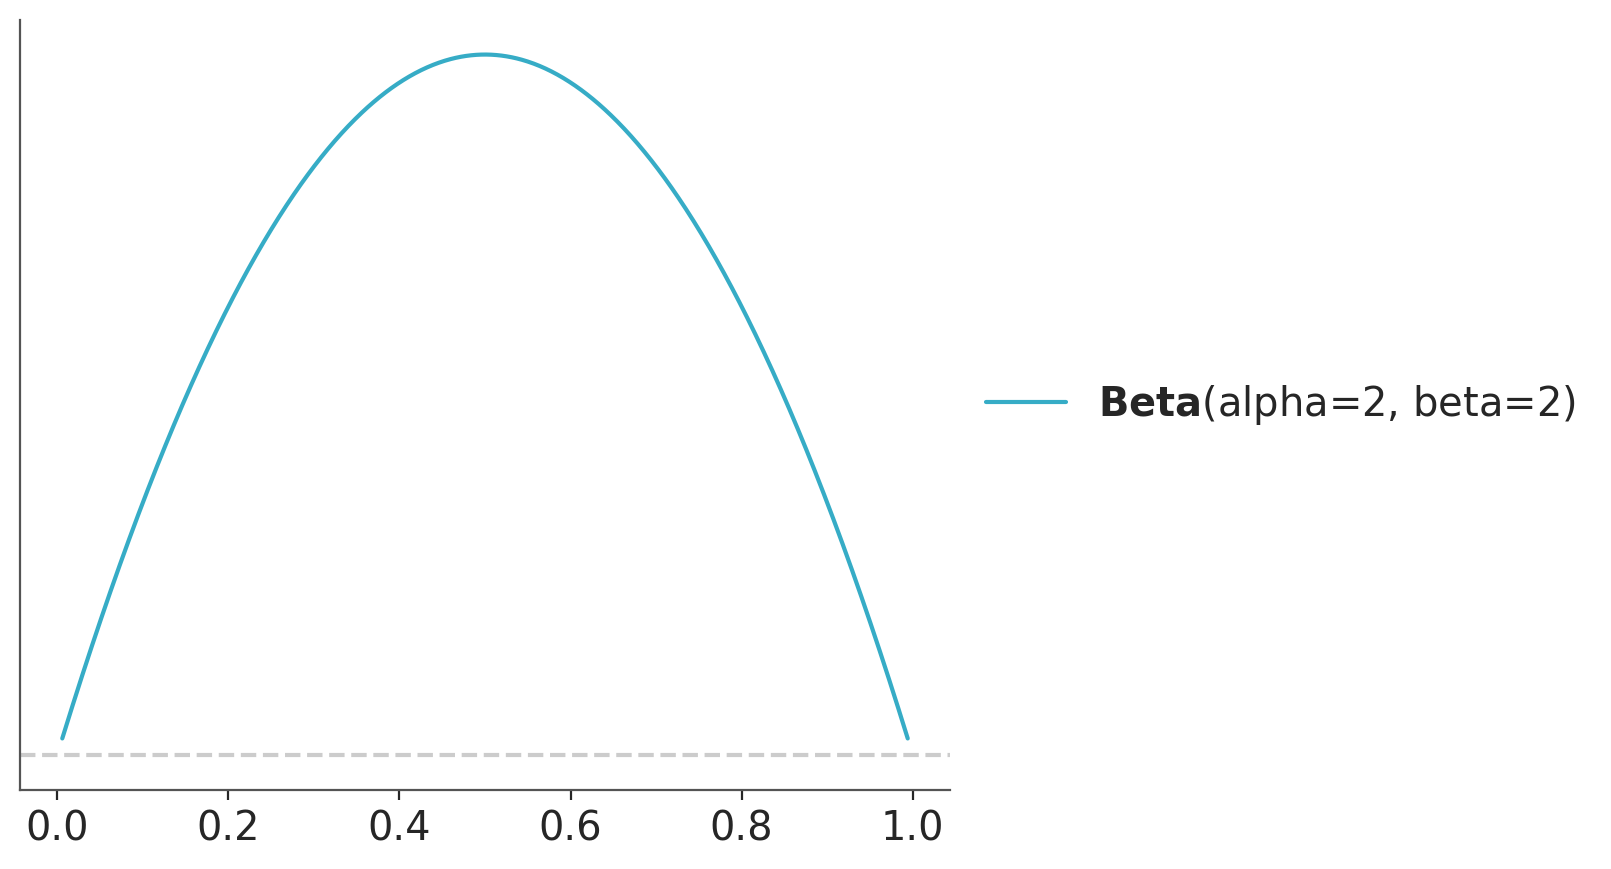

In [6]:
pz.plot(θ);

PreliZ's also has distributions, that follow the same parameterization as PyMC.

In [7]:
pz.Beta(alpha=2., beta=2.).plot_interactive(xy_lim="auto", figsize=(8, 4));

Now that we have defined the model and are satisfied with it, we can proceed to fit it to the data. We can use PyMC's sampling methods to draw samples from the posterior distribution of the model parameters. By default, PyMC uses the No-U-Turn Sampler (NUTS), a variant of Hamiltonian Monte Carlo (HMC), which is efficient for high-dimensional models.

In [8]:
with our_first_model:
    idata = pm.sample(1000, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


ArviZ can help us analyze and visualize the results of our Bayesian model. The default output of PyMC's sampling methods is the native data structure used by ArviZ.

In [9]:
az.summary(idata)

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
θ,0.38,0.16,0.14,0.65,1621.59,2245.28,1.0,0.0,0.0


We can also visualize the posterior distribution of $\theta$ using ArviZ's plotting functions.

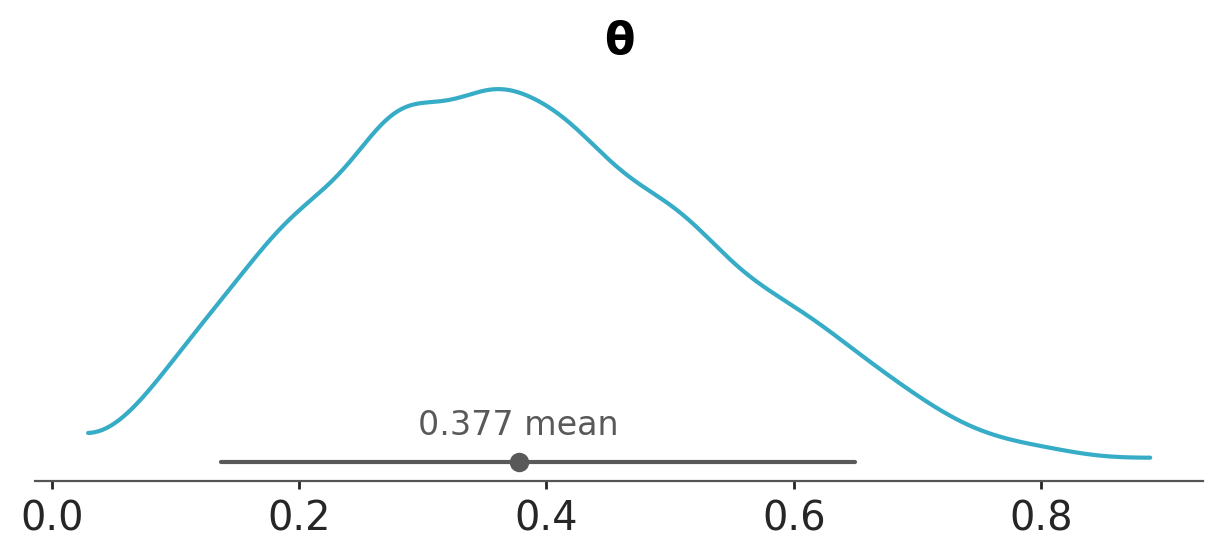

In [10]:
az.plot_dist(idata);

The `idata` object contains all the information about the model fit. The information is organized into groups, including

* `posterior`: contains samples from the posterior distribution of the model parameters.
* `posterior_predictive`: contains samples from the prior distribution of the model parameters.
* `observed_data`: contains the observed data used to fit the model.    
* `log_likelihood`: contains the log-likelihood of the observed data given the model parameters.
* other groups ...


Not all groups are always present, for example the `posterior` group is only present if we have sampled from the posterior distribution.

Each group can have multiple variables (like `theta` in the `posterior` group) and each variable can have multiple dimensions (like `chains` and `draws`).


In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Comparing groups

In [12]:
tips = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


* Let say we want to compare the tips given at different days of the week, Thursday, Friday, Saturday and Sunday
* We decided to use a Gamma distribution to model the tips
* We need to define one per day of the week

We could write the model like this:

```python
with pm.Model() as comparing_groups:
    mu0 = pm.Normal('mu0', mu=0, sigma=5)
    mu1 = pm.Normal('mu1', mu=0, sigma=5)
    mu2 = pm.Normal('mu2', mu=0, sigma=5)
    mu3 = pm.Normal('mu3', mu=0, sigma=5)
    sigma0 = pm.HalfNormal('sigma0', sigma=1)
    sigma1 = pm.HalfNormal('sigma1', sigma=1)
    sigma2 = pm.HalfNormal('sigma2', sigma=1)
    sigma3 = pm.HalfNormal('sigma3', sigma=1)
    
    ....
```

But that's too tedious and error-prone. Instead we can write it in vectorized form:

```python
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sigma=5, shape=4)
    σ = pm.HalfNormal('σ', sigma=1, shape=4)
    
    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip)
```

Yet another way is to use `coords` and `dims` to define the model more explicitly. This is especially useful when working with more complex models or larger datasets. It helps during model definition as we can think in terms of "labels", and afterwards we can use those labels to index and select data more easily, for example ArviZ plotting functions will use those labels to create more informative plots.

In [13]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [14]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    mu = pm.HalfNormal("mu", sigma=5, dims="days")
    sigma = pm.HalfNormal("sigma", sigma=1, dims="days")

    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample(random_seed=SEED)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

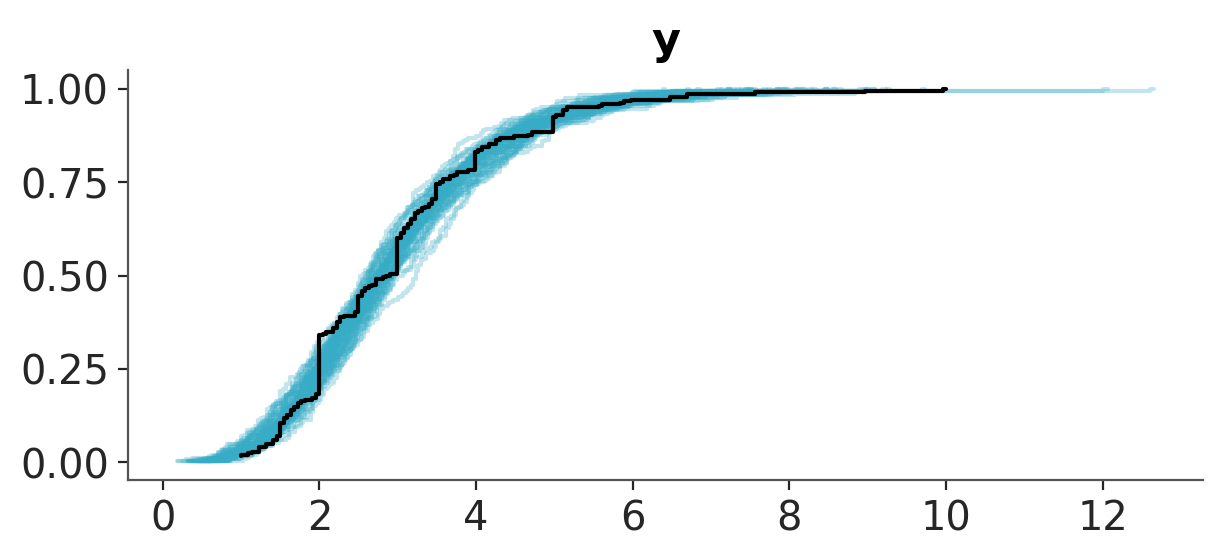

In [15]:
az.plot_ppc_dist(idata_cg, kind="ecdf");

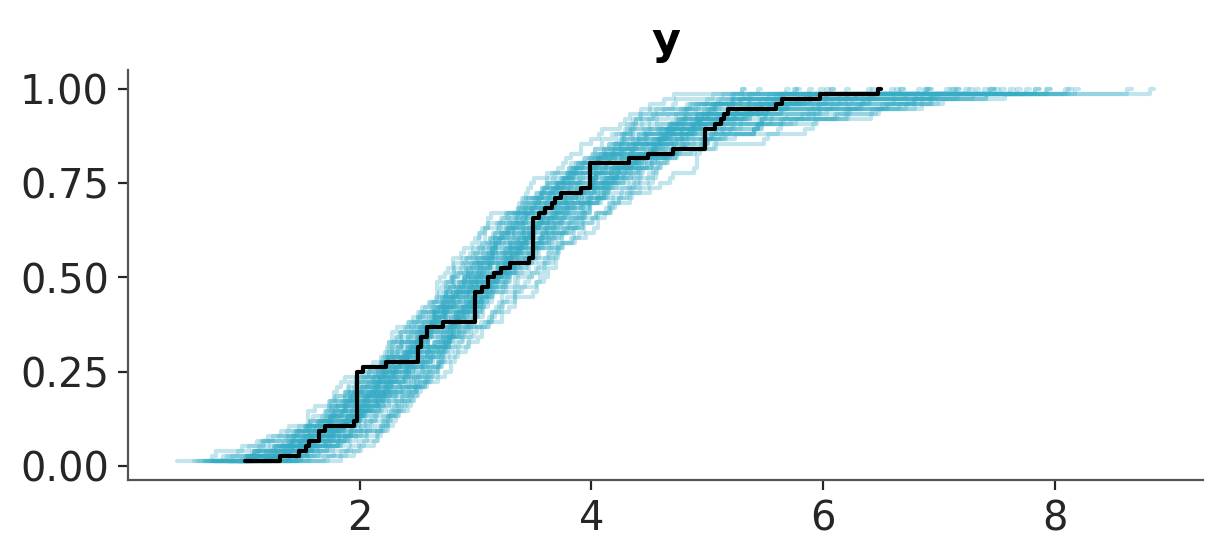

In [16]:
az.plot_ppc_dist(idata_cg, kind="ecdf", coords={"days_flat": "Sun"});

In [17]:
idata_cg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

## Hierarchical models

In this example we define two models one unpooled and one hierarchical (partially pooled) to analyze the same data.
In this example, the data consists on a quantity measured to amino acids in different proteins. It's "natural" to group the measurements by amino acid, as we expect that measurements from the same amino acid to be more similar to each other than measurements from different amino acids.

In [18]:
cs_data = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/chemical_shifts_theo_exp.csv")
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}
coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [19]:
with pm.Model(coords=coords) as cs_nh:         
    mu = pm.Normal('mu', mu=0, sigma=1, dims="aa") 
    sigma = pm.HalfNormal('sigma', sigma=1, dims="aa")
    nu = pm.Exponential('nu', 1/30)
  
    y = pm.StudentT('y', mu=mu[idx], sigma=sigma[idx], nu=nu, observed=diff) 
     
    idata_cs_nh =  pm.sample(idata_kwargs={"log_likelihood": True},  # Here we ask to compute the log_likelihood
                           random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [20]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    mu_mu = pm.Normal('mu_mu', mu=0, sigma=1)
    mu_sd = pm.HalfNormal('mu_sd', 1)

    # priors
    mu = pm.Normal('mu', mu=mu_mu, sigma=mu_sd, dims="aa") 
    sigma = pm.HalfNormal('sigma', sigma=1, dims="aa")
    nu = pm.Exponential('nu', 1/30)
    

    # likelihood
    pm.StudentT('y', mu=mu[idx], sigma=sigma[idx], nu=nu, observed=diff) 
    idata_cs_h = pm.sample(idata_kwargs={"log_likelihood": True},  # Here we ask to compute the log_likelihood
                           random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sd, mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [21]:
from IPython.display import HTML

g1 = cs_nh.to_graphviz()
g2 = cs_h.to_graphviz()

svg1 = g1.pipe(format="svg").decode("utf-8")
svg2 = g2.pipe(format="svg").decode("utf-8")

HTML(f"""
<div style="display:flex; gap:20px; align-items:flex-end;">
  <div>{svg1}</div>
  <div>{svg2}</div>
</div>
""")



To visualize the results we decided to compare the posterior distributions of the means for each amino acid in both models side by side.

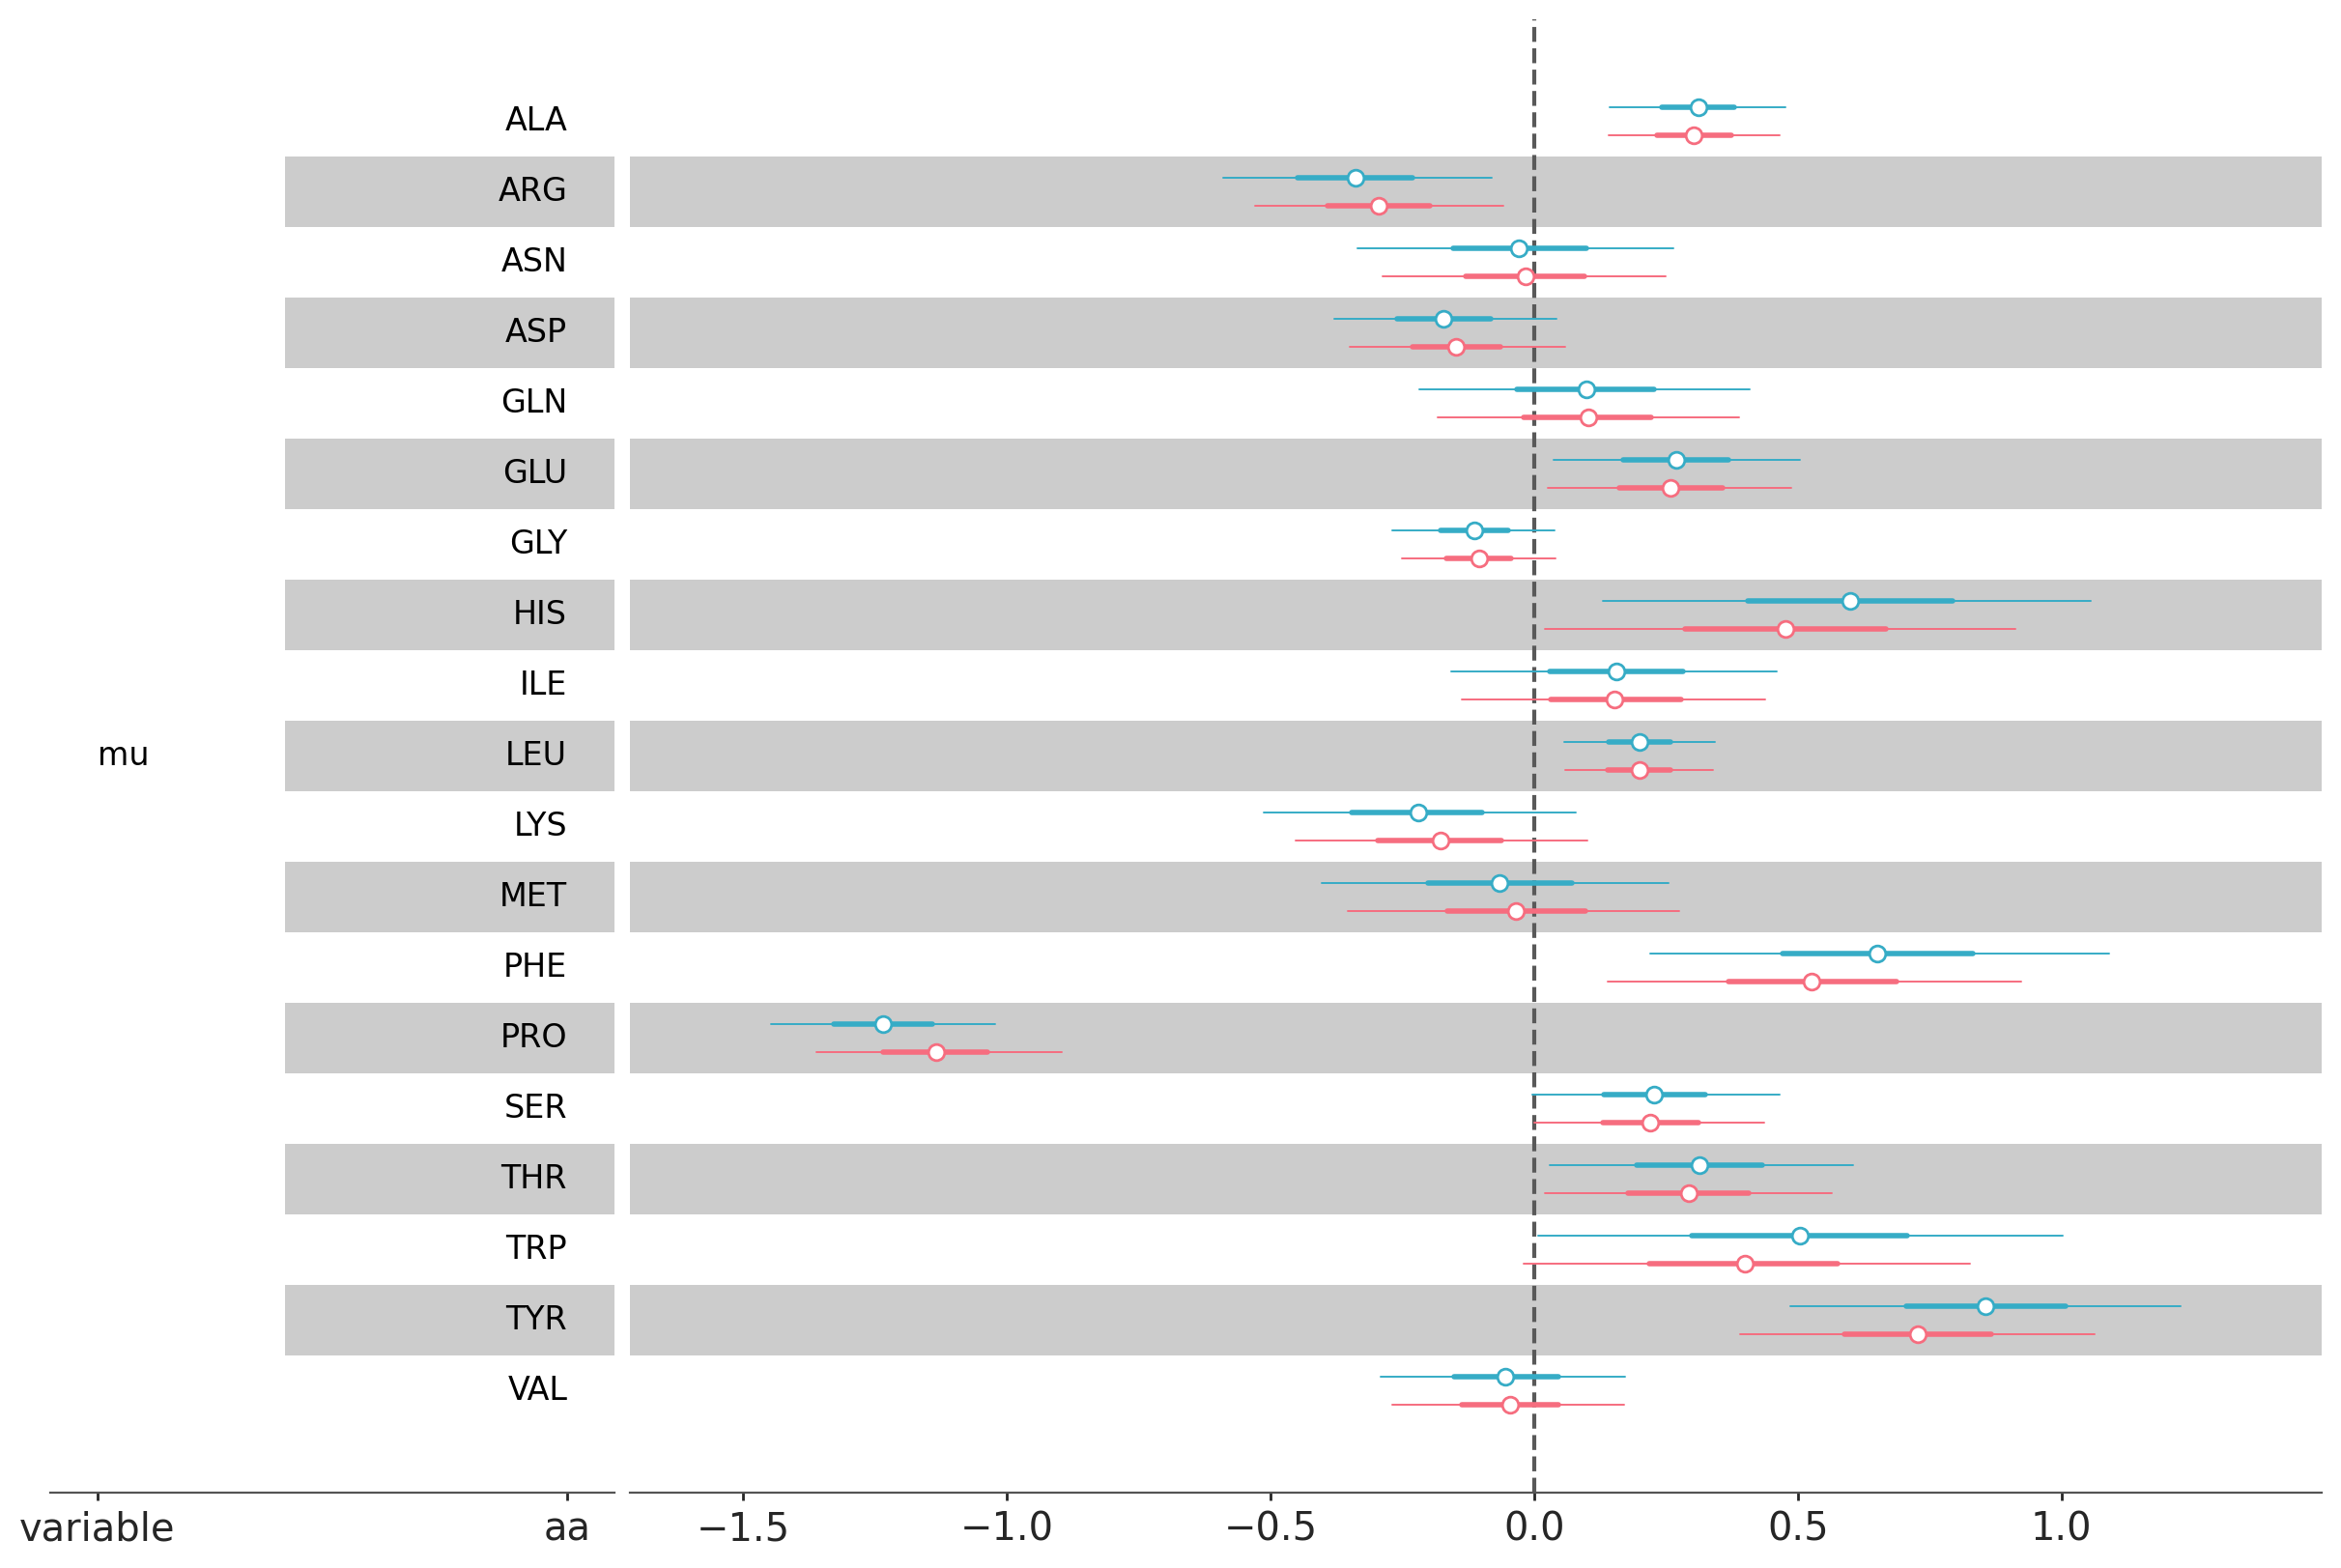

In [22]:
pc = az.plot_forest({"non_hierarchical": idata_cs_nh, 
                     "hierarchical": idata_cs_h},
                    var_names='mu',
                    combined=True,  # we combine all chains into a single distribution per group
                    shade_label="aa",  # we use the amino acid as the shading label
                    figure_kwargs={"figsize": (12, 8)}
)
# add a reference line at 0 (no difference)
pc.coords = {"column": "forest"} 
az.add_lines(pc, values=0);

We can also compare models in terms of their predictive accuracy using PSIS-LOO-CV. 

In [23]:
cmp = az.compare({"non_hierarchical": idata_cs_nh, 
                  "hierarchical": idata_cs_h},
                )
cmp.round(1)

,rank,elpd,p,elpd_diff,weight,se,dse,warning
hierarchical,0,-3359.3,36.3,0.0,0.8,38.3,0.0,False
non_hierarchical,1,-3359.7,38.0,0.4,0.2,38.2,1.3,False


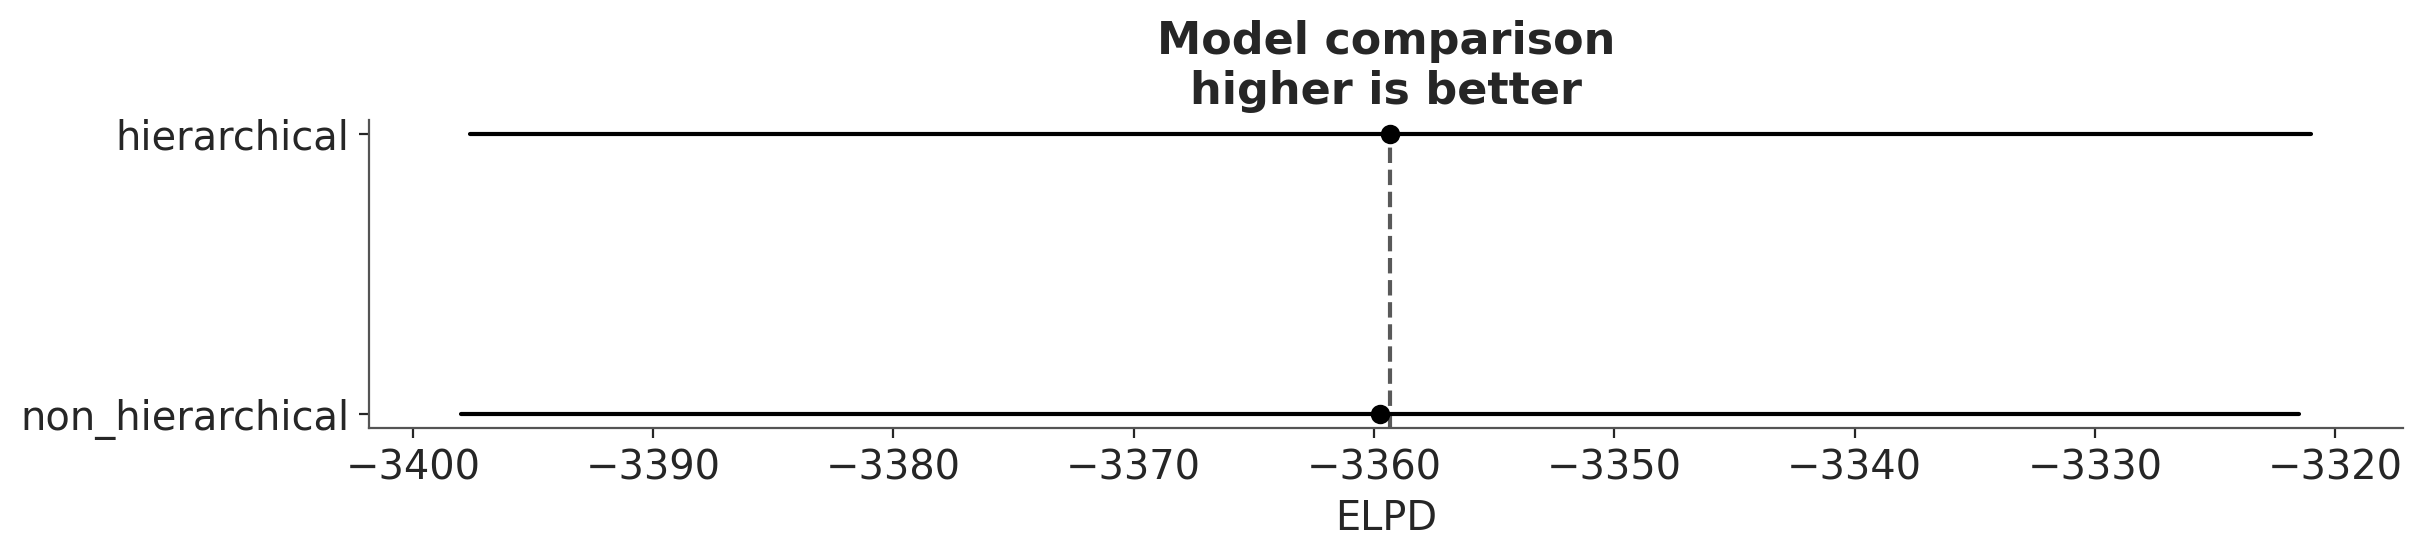

In [24]:
az.plot_compare(cmp);

## Bambi

Now we are going to switch to Bambi, a high-level interface for building Bayesian models using formula syntax similar to R's `lme4` or Python's `statsmodels`. Bambi is built on top of PyMC and integrates seamlessly with ArviZ for model analysis and visualization.

If you want finer use PyMC directly. If you want a higher-level interface Bambi is a great choice. It allows you to define generalized linear models (GLMs), including hierarchical models, interactions. It also support splines and Gaussian processes (HSGPs). By default Bambi uses very weakly informative priors, but you can customize them as needed.

In [25]:
bikes = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/bikes.csv")

In [26]:
model_th = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
model_th

       Formula: rented ~ temperature + humidity
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.6708)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
            humidity ~ Normal(mu: 0.0, sigma: 13.2417)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)

In [27]:
idata_th = model_th.fit(random_seed=SEED)  # compute posterior
model_th.predict(idata_th, kind="response")  # compute posterior predictive

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, temperature, humidity]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


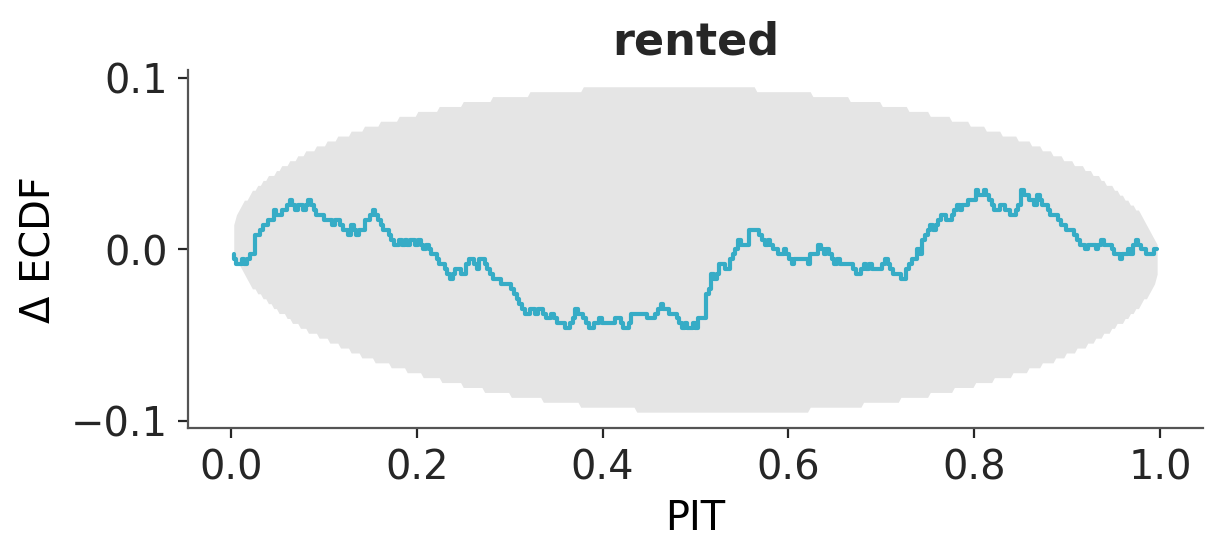

In [28]:
az.plot_ppc_pit(idata_th);

One of the nice features of Bambi is it's `interpret` submodule that features a set of tools used to interpret regression models in the spirit of [https://marginaleffects.com/](https://marginaleffects.com/).

For example we can use the `plot_predictions` function to visualize how the number of rented bikes varies with temperature, for different values of humidity.

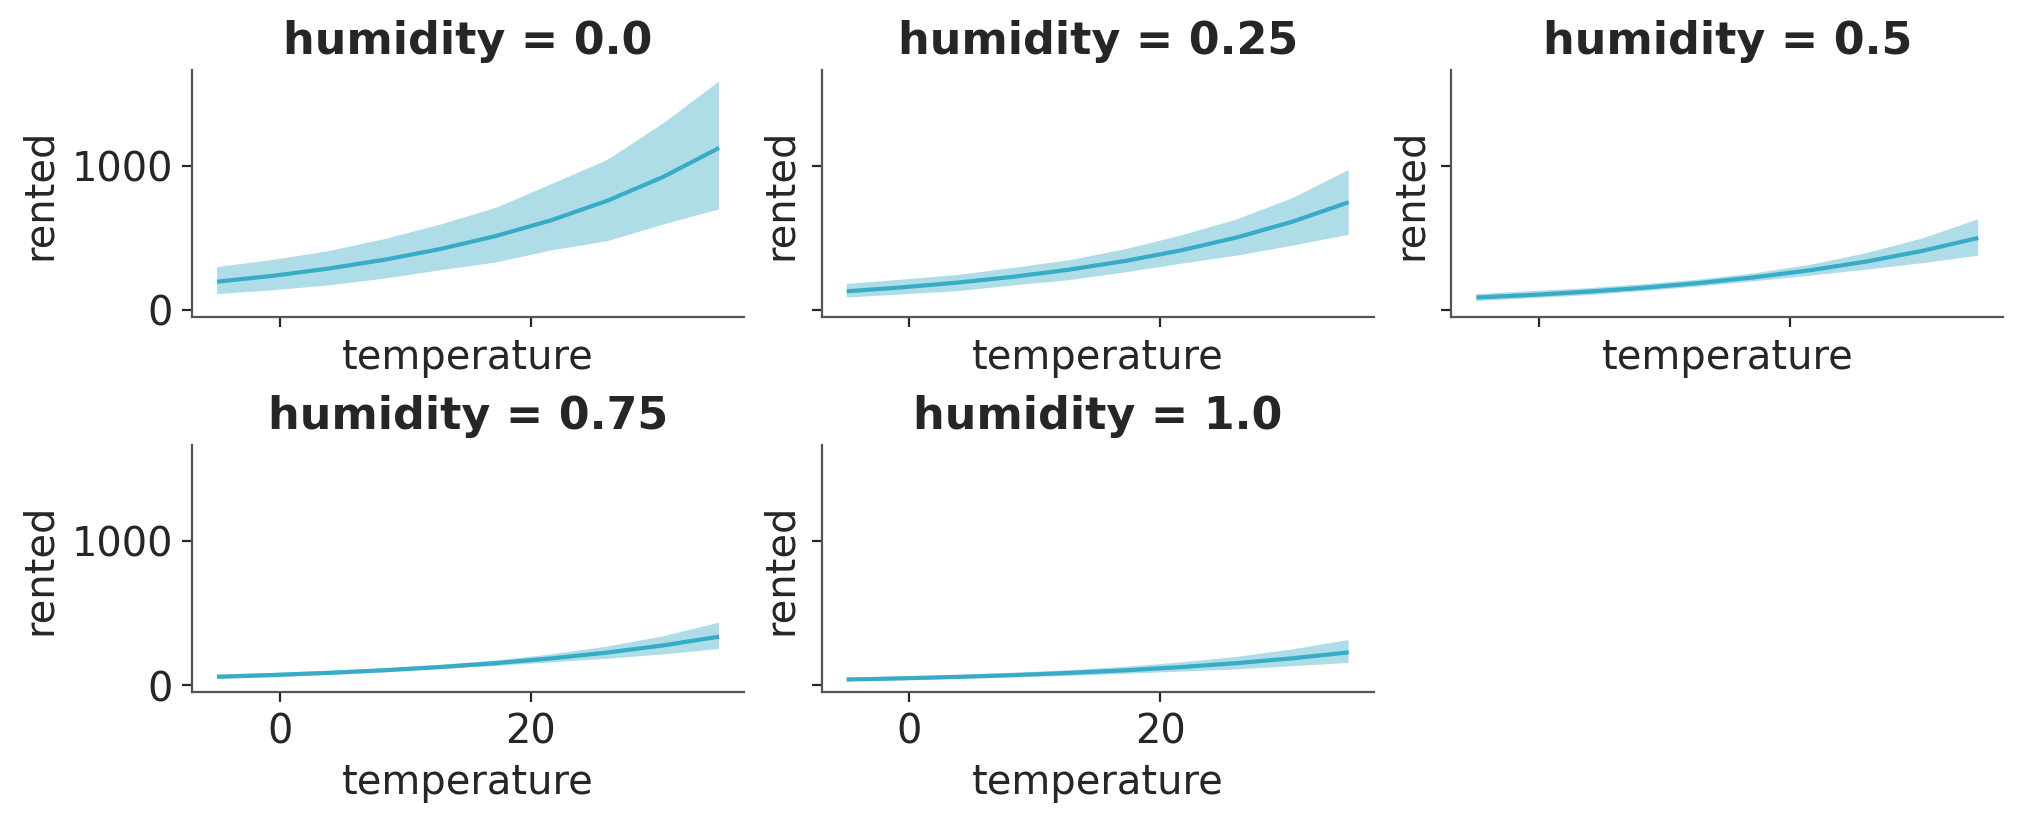

In [29]:
bmb.interpret.plot_predictions(model_th,
                               idata_th,
                               conditional={"temperature": np.linspace(-5, 35, 10), "humidity": np.linspace(0, 1, 5)},
                               subplot_kwargs={"group":None, "panel":"humidity"},
                               fig_kwargs={"sharey":True, "sharex":True, "figsize": (10, 4)}
                               );

Now let's move to variable selection. The aim of the analysis is to predict an expensive and cumbersome water immersion measurement of body fat percentage (observed variable named `siri`) from a set of thirteen easier to measure characteristics, including `age`, `height`, `weight`, and circumferences of various body parts

In [30]:
body = pd.read_csv("https://raw.githubusercontent.com/bambinos/kulprit/refs/heads/main/docs/examples/body_fat.csv")

We first fit a full model including all predictors. We should check that the model is well specified we don't have sampling issues like divergences or low effective sample sizes and that the posterior predictive checks look good. But for brevity we will skip those steps here.

In [31]:
model = bmb.Model("siri ~" +  " + ".join([c for c in body.columns if c!="siri"]), data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, weight, height, neck, chest, abdomen, hip, thigh, knee, ankle, biceps, forearm, wrist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


We can then use Kulprit to perform variable selection.

In [32]:
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'biceps']
  5 ['abdomen', 'weight', 'wrist', 'biceps', 'age']
  6 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck']
  7 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height']
  8 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle']
  9 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle', 'chest']
 10 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle', 'chest', 'forearm']
 11 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle', 'chest', 'forearm', 'thigh']
 12 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle', 'chest', 'forearm', 'thigh', 'knee']
 13 ['abdomen', 'weight', 'wrist', 'biceps', 'age', 'neck', 'height', 'ankle', 'chest', 'forearm', 'thigh', 'knee', 'hip']

We can ask Kulprit to select the model for us based on some heuristic.

In [33]:
ppi.select()

['Intercept', 'abdomen', 'weight']

But it's usually better to look at the plot of the predictive performance versus the model size

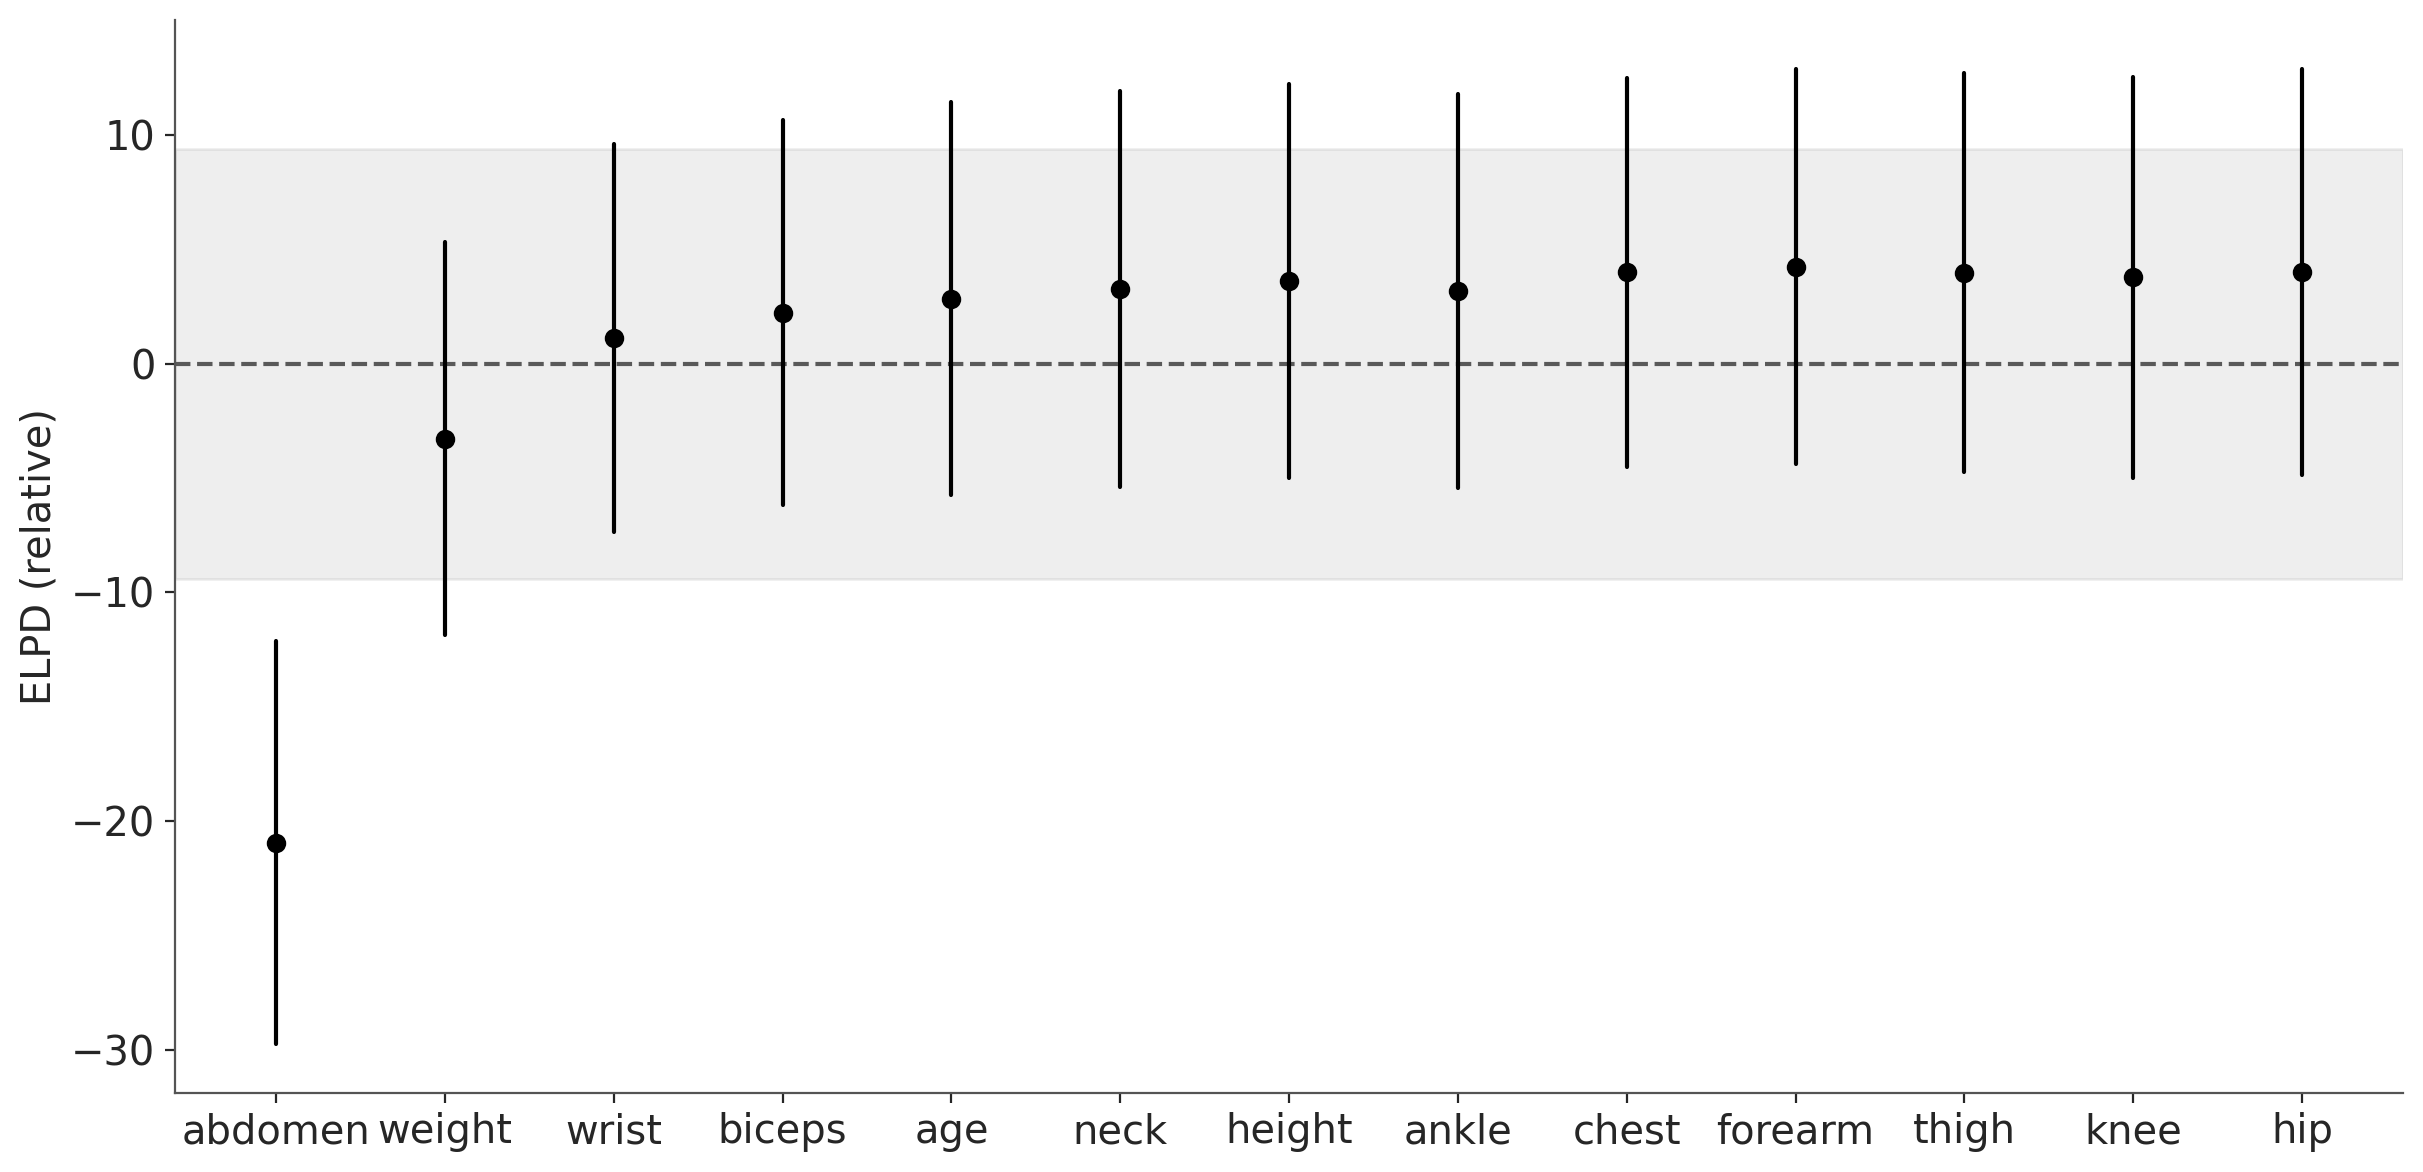

In [34]:
cmp_df = ppi.compare(min_model_size=1, round_to=2)
kpt.plot_compare(cmp_df);